In [1]:
%%capture
!pip install pyspark

In [2]:
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from pyspark import SparkConf, SparkContext

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
spark = (
    SparkSession
    .builder
    .appName("app")
    .getOrCreate()
)

sc = spark.sparkContext
spark.sparkContext.setLogLevel("WARN")

#### Повторяем действия из главы 3


In [4]:
results = (
    spark.read.text('/content/gdrive/MyDrive/*.txt')
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .where(f.col("word") != "")
    .groupby(f.col("word"))
    .count()
)
results.show(5)

+------+-----+
|  word|count|
+------+-----+
|online|   24|
|  some| 1551|
|   art|  100|
|voyage|  120|
| those|  600|
+------+-----+
only showing top 5 rows



Вкладка Jobs spark ui
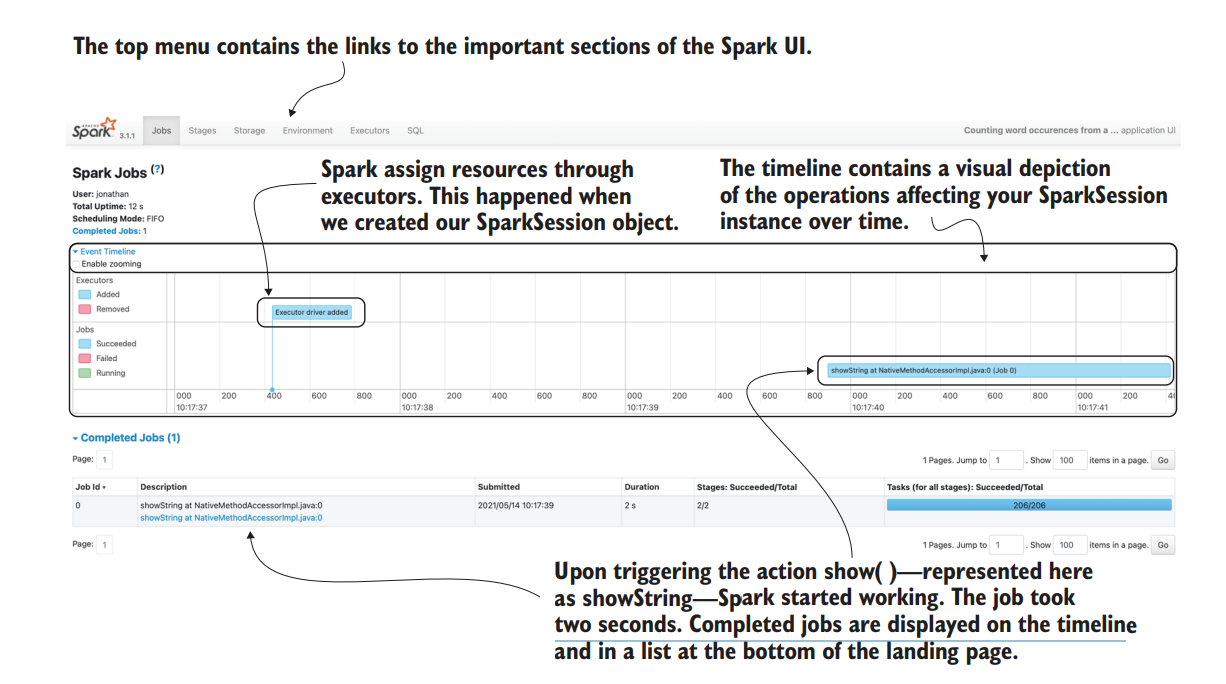

Вкладка Environment  
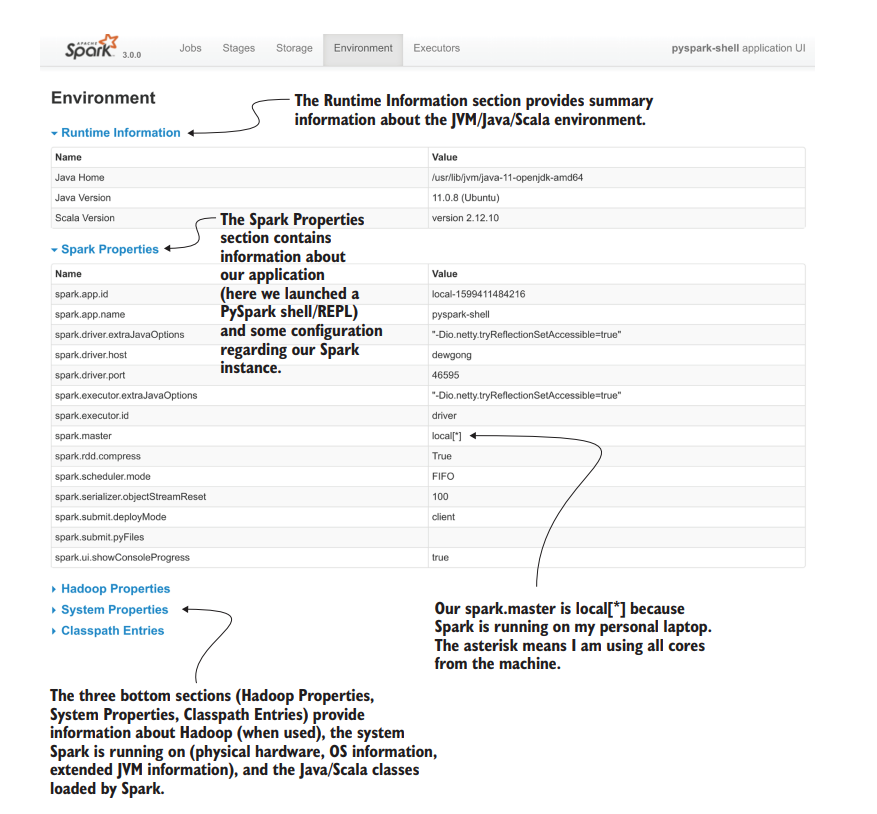

Вкладка Executors.  
По умолчанию спарк выделяет 1gb памяти для драйвера, но на изображении мы видим 434 мебибайт (MiB=2^20 bytes, Mb=10^6 bytes)
Память в pyspark распределяется на 3 части:  
1) Зарезервированная память (Reserved) для хранения внутренней информации spark, необходимой для его работы  
2) Оперативная память (Operational) для вычислений и работы с данными. Может хранить например агрегаты и промежуточные выводы  
3) Память для хранения (Storage) хранит данные, кэшированные пользователем (например DF), для обеспечения быстрого доступа к ним. Кэширование происходит с помощью специальных команд, при чтении данные не кэшируются автоматически  
434 mib включает в себя Operational и Storage память  
M - параметр spark.{driver|executor}.memory - сколько всего выделено памяти на драйвер и экзекуторы (дефолт - 1g)  
F - параметр spark.memory.fraction - доля памяти, которая будет выделена на operational и storage (дефолт - 0.6)  
S - spark.memory.storageFraction - доля на память storage из M*F (дефолт - 0.5)  
при старте spark выделяет для себя Reserved 300 MiB до разбиения.  
(1 GiB - 300 MiB) * 0.6 = 434.4MiB  
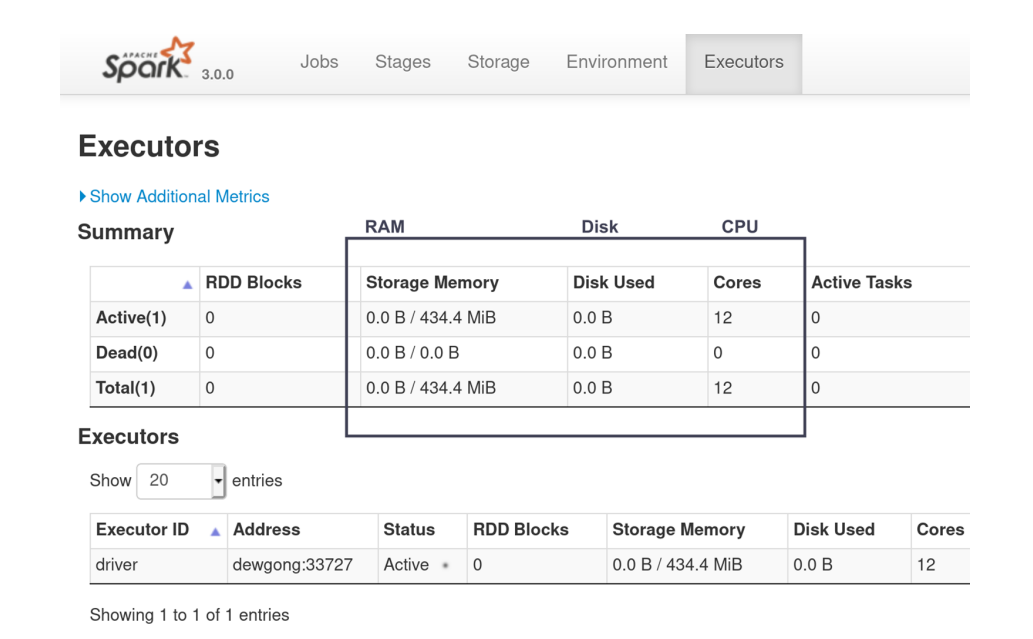

схема вычислений  
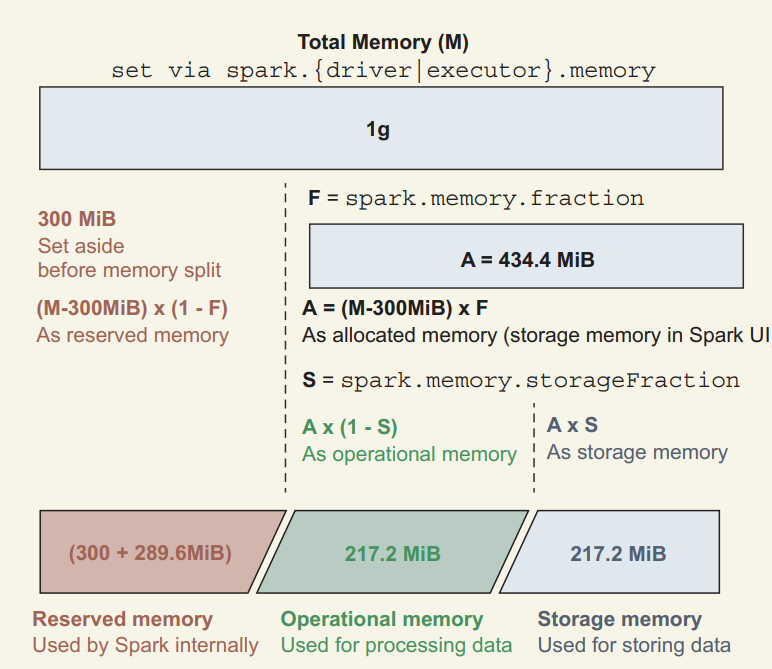

Сокращения для выделения памяти  
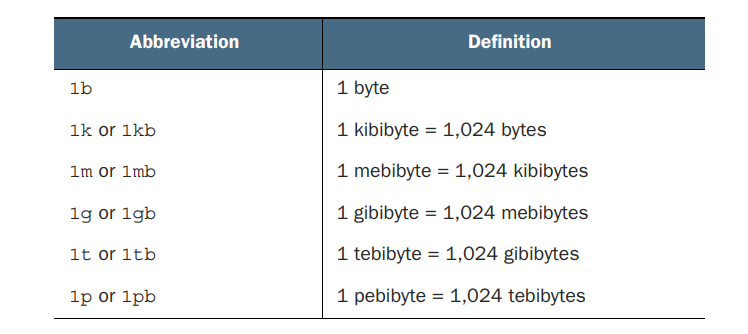

используем 8 ядер процессора  
драйвер бeдет использовать 10gb памяти (по умолчанию 1)

In [5]:
spark = (
    SparkSession.builder.appName("Launching PySpark with custom options")
    .master("local[8]")
    .config("spark.driver.memory", "10g")
).getOrCreate()


In [6]:
results = (
    spark.read.text('/content/gdrive/MyDrive/*.txt')
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .filter(f.col("word") != "")
    .groupby(f.col("word"))
    .count()
    .show(20)
)

+----------+-----+
|      word|count|
+----------+-----+
|    online|   24|
|      some| 1551|
|       art|  100|
|    voyage|  120|
|     those|  600|
|  currents|    8|
|       few|  382|
|     still|  728|
|    travel|   14|
| connected|   47|
|  bowsprit|    8|
|  besmoked|    1|
|     spoil|    7|
|   persist|    3|
|  blackish|    1|
|concluding|   13|
|      hope|  273|
| solemnity|   11|
|    doubts|   16|
|       fog|    6|
+----------+-----+
only showing top 20 rows



После запуска цепочки преобразований методом show(), count(), write(), в spark job можно увидеть ее выполнение  
в данной ситуации задача выполнилась в 2 этапа:  
1) Stage 0 - чтение 6ти файлов, преобразования, фильтрация группировка, аггрегирование.  
Промежуточный этап - обмен файлами между узлами  
2) Stage 1 - выбор 20ти элементов df, их финальная аггрегация, так как одинаковые слова могли быть в разных партициях, вывод результа на экран
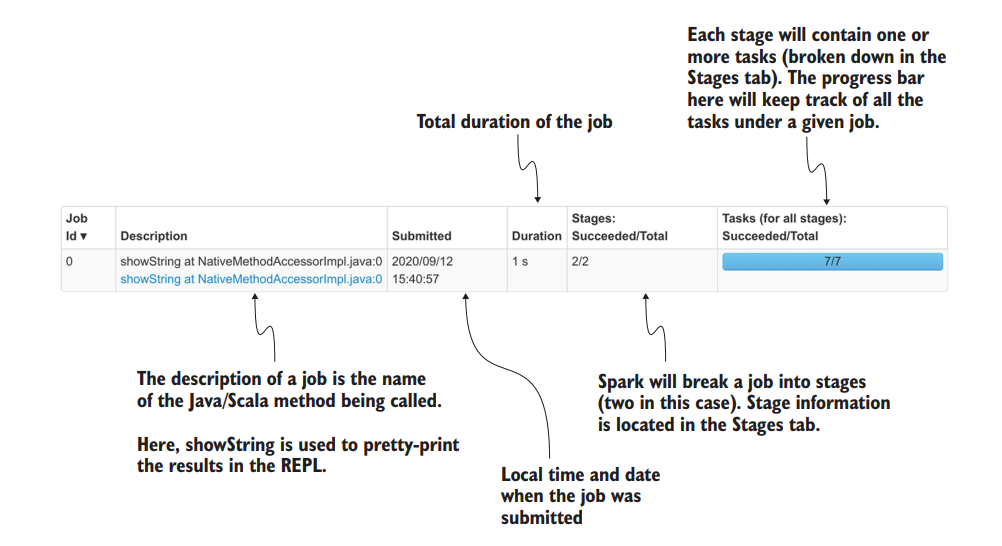

input - данные, которые читаем с хранилища  
output - данные, которые сохраняем на хранилище (пропуск, так как этой операции нет)
shufle write - данные, которые записаны после Stage 0 на моменте обмена файлами между узлами
shufle read - данные, которые считались на этапе Stage 1 со всех нод. Их меньше, так как spark понимает, что для отображения требуется только 20 записей

Заданий не 7, а 3, так как автор делал вычисление на облачной платформе с другой конфигурацией  
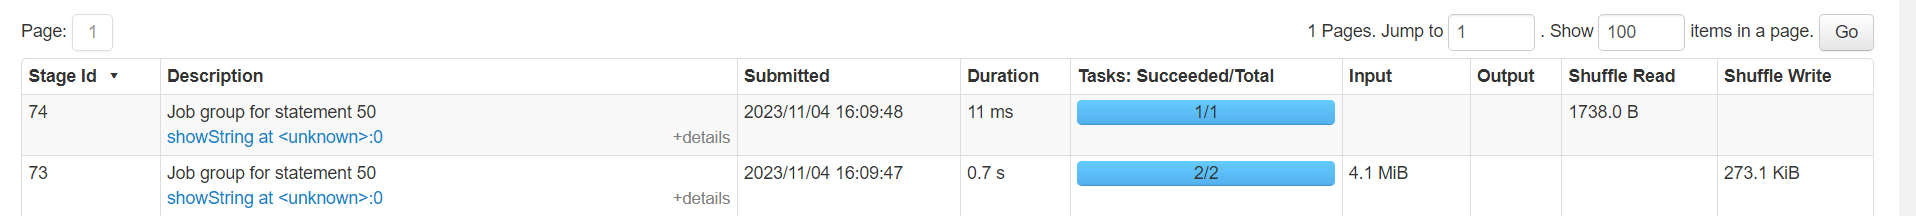

схема выполнения этапов. Exchange - этап обмена файлами
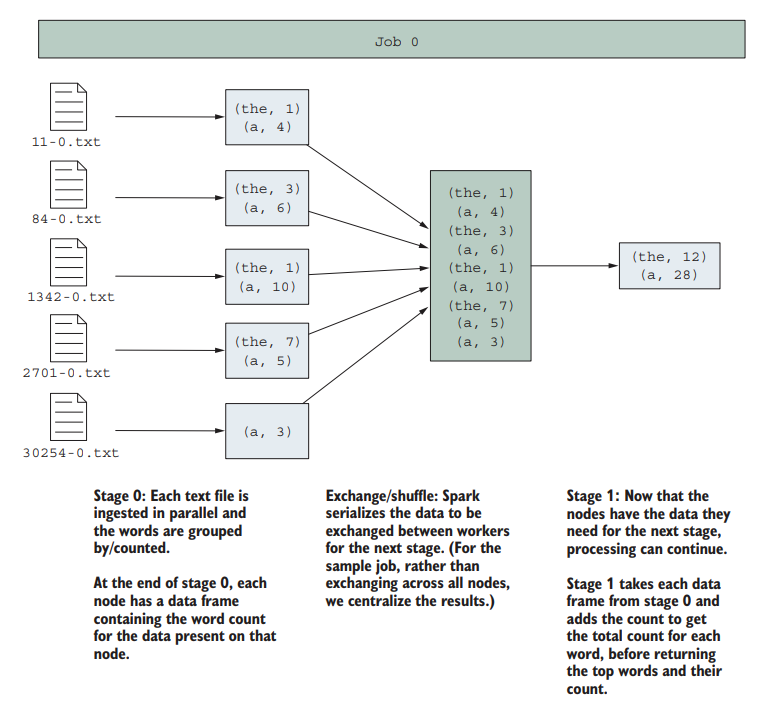

#### вкладка sql

если навести мышку на первый блок, то появится информация о том, какие файлы прочитал spark
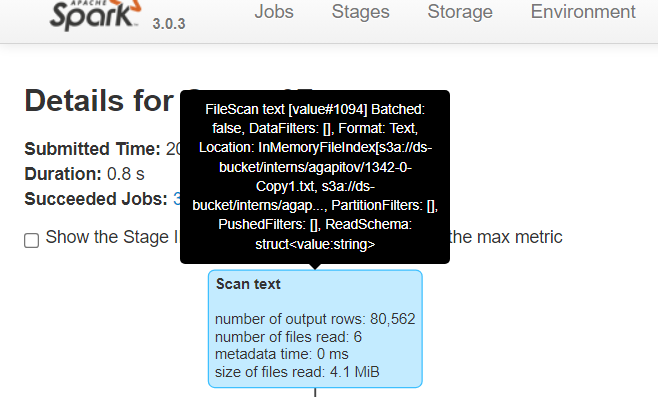

Спарк принимает Python код и переводит в спарковые инструкции. Инструкции кодируются в план запросов и отправляются на исполнителей. Планы делятся на 4 типа parsed, analyzed, optimized physical  
к данным применяется физический план
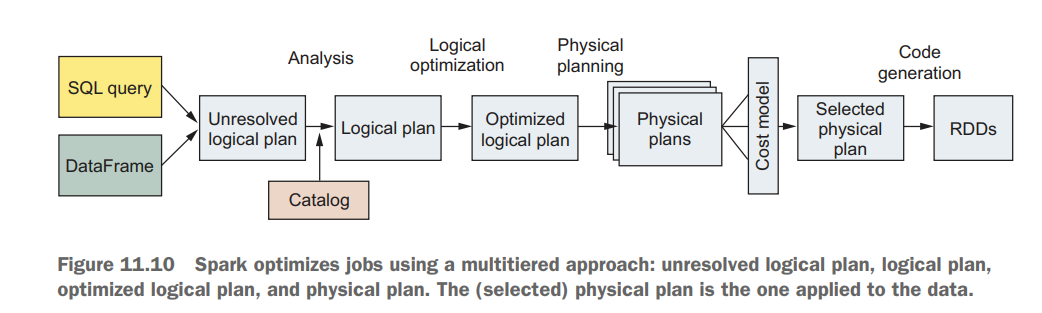

Полный план можно увидеть в UI или вызвав метод explain. Читается снизу вверх

In [7]:
results = (
    spark.read.text('/content/gdrive/MyDrive/*.txt')
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .filter(f.col("word") != "")
    .groupby(f.col("word"))
    .count()
)
results.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['word], ['word, count(1) AS count#72L]
+- Filter NOT (word#68 = )
   +- Project [regexp_extract(word#66, [a-z']+, 0) AS word#68]
      +- Project [lower(word#64) AS word#66]
         +- Project [word#64]
            +- Generate explode(line#60), false, [word#64]
               +- Project [split(value#58,  , -1) AS line#60]
                  +- Relation [value#58] text

== Analyzed Logical Plan ==
word: string, count: bigint
Aggregate [word#68], [word#68, count(1) AS count#72L]
+- Filter NOT (word#68 = )
   +- Project [regexp_extract(word#66, [a-z']+, 0) AS word#68]
      +- Project [lower(word#64) AS word#66]
         +- Project [word#64]
            +- Generate explode(line#60), false, [word#64]
               +- Project [split(value#58,  , -1) AS line#60]
                  +- Relation [value#58] text

== Optimized Logical Plan ==
Aggregate [word#68], [word#68, count(1) AS count#72L]
+- Project [regexp_extract(lower(word#64), [a-z']+, 0) AS word#6

в UI можно увидеть этап locallimit, который отражает метод show()  
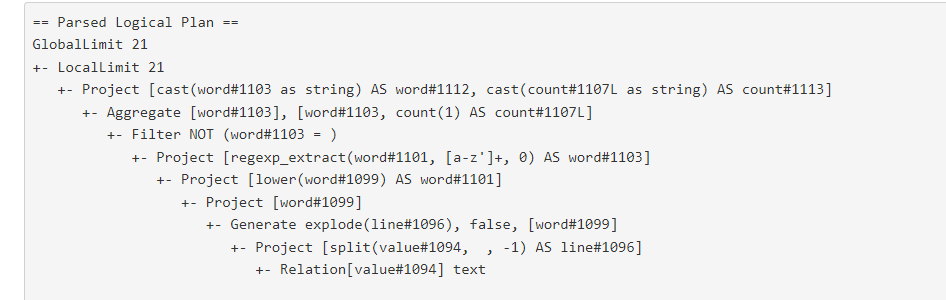

в Analyzed Logical Plan spark уже знает схему выходных данных  
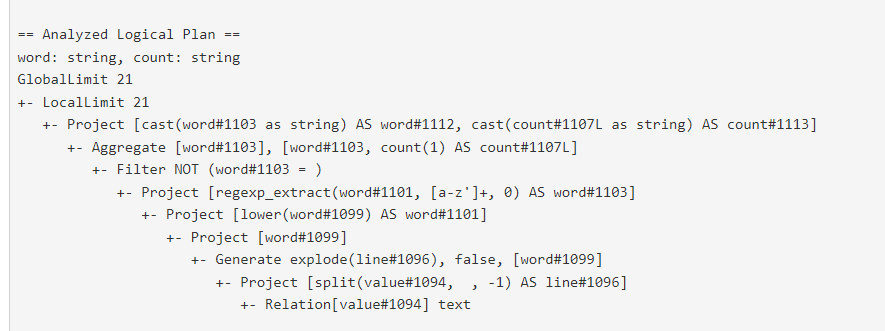

Optimized Logical Plan оптимизирует логический план  
1) перед операцией explode отсутствует Project[word#1099], так как не требуется явно создавать данную колонку, она нужна только для логических вычислений  
2) Операции regexp_extract и lower и filter объединяются в один шаг  


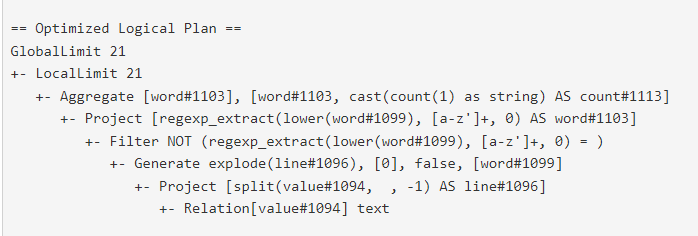

Физический план  
 цифры *(n) соответсвуют WholeStageCodegen - метод оптимизации при котором несколько пунктов физического плана могут быть оъединены в одну java ф-ию

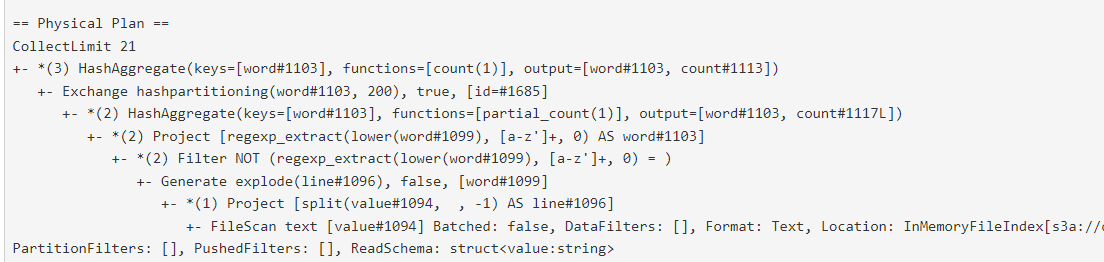

#### узкие, широкие преобразования  
узкое преобразование - преобразование, которое применяется к каждой записи независимо, например lower, regexp_extract
широкое преобразование требует, чтобы данные были распределены определенным образом между узлами. Например max, groupby join  
Именно для широких преобразований используется шаг обмена, так ка данные нужно перетасовать, чтобы например получить правильный агрегат, что требовалось в задании выше и выполнялось на Stage 0

пример плохой программы, так как широкая операция повторяется 2 раза

In [8]:
results = (
    spark.read.text("/content/gdrive/MyDrive/*.txt")
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .where(f.col("word") != "")
    .groupby(f.col("word"))
    .count()
    .where(f.length(f.col("word")) > 8)
    .groupby(f.length(f.col("word")))
    .sum("count")
)
results.show(5, False)
results.explain('formatted')

+------------+----------+
|length(word)|sum(count)|
+------------+----------+
|12          |3510      |
|13          |1631      |
|16          |38        |
|20          |1         |
|15          |165       |
+------------+----------+
only showing top 5 rows

== Physical Plan ==
AdaptiveSparkPlan (13)
+- HashAggregate (12)
   +- Exchange (11)
      +- HashAggregate (10)
         +- HashAggregate (9)
            +- Exchange (8)
               +- HashAggregate (7)
                  +- Project (6)
                     +- Filter (5)
                        +- Generate (4)
                           +- Project (3)
                              +- Filter (2)
                                 +- Scan text  (1)


(1) Scan text 
Output [1]: [value#77]
Batched: false
Location: InMemoryFileIndex [file:/content/gdrive/MyDrive/Colab Notebooks/pyspark/ch3_group_order/files/11-0.txt, ... 5 entries]
ReadSchema: struct<value:string>

(2) Filter
Input [1]: [value#77]
Condition : ((size(split(value#77,  , 

исправленная программа стала работать быстрее

In [9]:
results = (
    spark.read.text("/content/gdrive/MyDrive/*.txt")
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .where(f.col("word") != "")
    .where(f.length(f.col("word")) > 8)
    .groupby(f.length(f.col("word")))
    .count()
)
results.show(5, False)
results.explain('formatted')

+------------+-----+
|length(word)|count|
+------------+-----+
|12          |3510 |
|13          |1631 |
|16          |38   |
|20          |1    |
|15          |165  |
+------------+-----+
only showing top 5 rows

== Physical Plan ==
AdaptiveSparkPlan (10)
+- HashAggregate (9)
   +- Exchange (8)
      +- HashAggregate (7)
         +- Project (6)
            +- Filter (5)
               +- Generate (4)
                  +- Project (3)
                     +- Filter (2)
                        +- Scan text  (1)


(1) Scan text 
Output [1]: [value#120]
Batched: false
Location: InMemoryFileIndex [file:/content/gdrive/MyDrive/Colab Notebooks/pyspark/ch3_group_order/files/11-0.txt, ... 5 entries]
ReadSchema: struct<value:string>

(2) Filter
Input [1]: [value#120]
Condition : ((size(split(value#120,  , -1), true) > 0) AND isnotnull(split(value#120,  , -1)))

(3) Project
Output [1]: [split(value#120,  , -1) AS line#122]
Input [1]: [value#120]

(4) Generate
Input [1]: [line#122]
Arguments: expl

#### Кэширование

Кэширование - процесс при котором df сереализуется в память storage, что обеспечивает быстрое обращение к нему. Например, если мы несколько раз вызываем метод show() для df, то каждый раз цепочка вычислений будет проходить с самого начала, что сильно замедляет скорость. Если df кэширован, то вычисления будут проводиться с "контрольной точки".    
кэширование происходит с помощью методов cache и persist

In [25]:
results = (
    spark.read.text("/content/gdrive/MyDrive/*.txt")
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .where(f.col("word") != "")
    .where(f.length(f.col("word")) > 8)
    .groupby(f.length(f.col("word")))
    .count()
)

In [26]:
%%time
for i in range(10):
    results.count()

CPU times: user 77.1 ms, sys: 9.68 ms, total: 86.8 ms
Wall time: 14.7 s


In [27]:
results = (
    spark.read.text("/content/gdrive/MyDrive/*.txt")
    .select(f.split(f.col("value"), " ").alias("line"))
    .select(f.explode(f.col("line")).alias("word"))
    .select(f.lower(f.col("word")).alias("word"))
    .select(f.regexp_extract(f.col("word"), "[a-z']+", 0).alias("word"))
    .where(f.col("word") != "")
    .where(f.length(f.col("word")) > 8)
    .groupby(f.length(f.col("word")))
    .count()
    .cache()
)

In [28]:
%%time
for i in range(10):
  results.count()

CPU times: user 12.2 ms, sys: 2.36 ms, total: 14.6 ms
Wall time: 1.76 s


если сереализированный df не будет вмещаться в storage, то будет использоваться память диска, что может негативно сказаться на производительности

UI storage при кэшировании

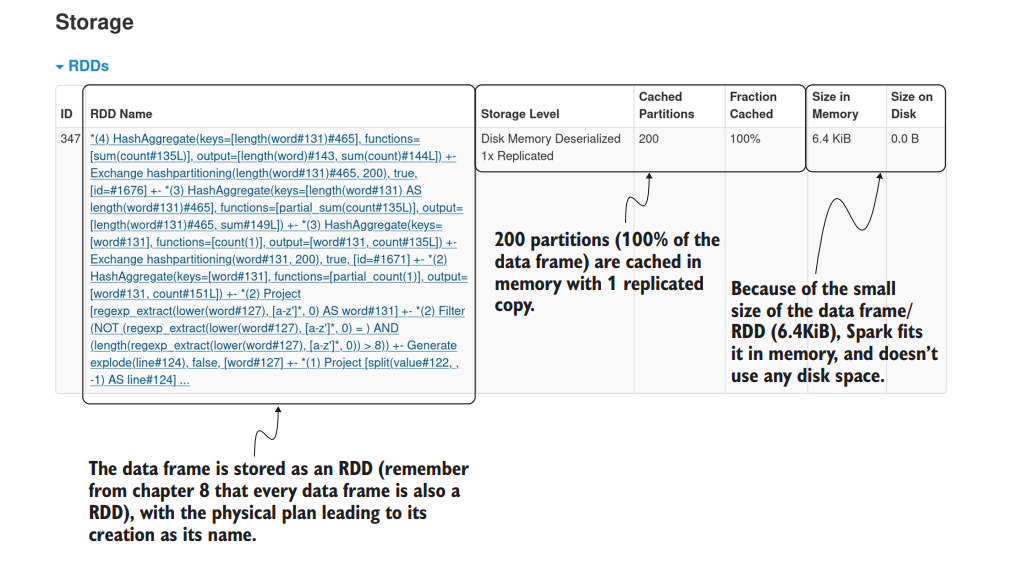